# Ensemble Model for Weather Forecasting

# Data load And Preparation

In [2]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.optimize import differential_evolution
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
warnings.filterwarnings('ignore')


In [8]:
pd.options.display.float_format = '{:,.10f}'.format
db = pd.read_csv('Bias_correction_ucl.csv').dropna()
db = db[db['station']==1]
db.columns

Index(['station', 'Date', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin',
       'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS',
       'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4',
       'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon',
       'DEM', 'Slope', 'Solar radiation', 'Next_Tmax', 'Next_Tmin'],
      dtype='object')

In [9]:
db['Date'] = pd.to_datetime(db['Date'])
df = pd.read_excel('graps.xlsx')
db = df.merge(db[['Date', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse']], on='Date', how='left')
db.head()

,Date,Temperatura Real,previsto_svr,previsto_rf,previsto_mlp,previsto_mme,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse
0,2017-06-30,29.2000000000,28.0440398829,27.3524000000,27.1887591130,27.5283996653,26.7983751400,20.8287135200
1,2017-07-01,24.1000000000,25.8503746813,23.8926000000,25.1000000000,24.9476582271,24.3613413300,22.5986772600
2,2017-07-03,29.9000000000,27.6964732923,28.2766000000,27.0360995078,27.6697242667,29.2454020900,21.7213791500
3,2017-07-04,30.0000000000,29.1014533072,29.8056000000,28.5593982244,29.1554838439,29.6111449800,22.4301356100
4,2017-07-05,31.2000000000,31.1787320339,31.6304000000,28.9461860697,30.5851060346,31.5103503600,22.6366783700


In [10]:
db.to_excel('graps2.xlsx')

In [4]:
pd.options.display.float_format = '{:,.10f}'.format
db = pd.read_csv('Bias_correction_ucl.csv').dropna()
db.Date = pd.to_datetime(db.Date)
db['Year'] = db.Date.dt.year
db = db.set_index(['station','Date','Year'])
db = db[(np.abs(stats.zscore(db)) < 6).all(axis=1)]
target = db[['Next_Tmax','Next_Tmin']]
features = db.drop(['Next_Tmax','Next_Tmin'],axis=1)


#### Data Transformation

In [5]:
x_scaler = StandardScaler()
norm_features = pd.DataFrame(x_scaler.fit_transform(features.values), columns=features.columns, index=features.index)
y_scaler_Tmax = StandardScaler()
y_scaler_fit_Tmax = y_scaler_Tmax.fit(
    np.array(target['Next_Tmax']).reshape(-1, 1))
target_norm_max = pd.DataFrame(y_scaler_Tmax.fit_transform(np.array(
    target['Next_Tmax']).reshape(-1, 1)), columns=target[['Next_Tmax']].columns, index=target[['Next_Tmax']].index)
y_scaler_Tmin = StandardScaler()
y_scaler_fit_Tmin = y_scaler_Tmin.fit(
    np.array(target['Next_Tmin']).reshape(-1, 1))
target_norm_Tmin = pd.DataFrame(y_scaler_Tmin.fit_transform(np.array(
    target['Next_Tmin']).reshape(-1, 1)), columns=target[['Next_Tmin']].columns, index=target[['Next_Tmin']].index)


## Train And Test Split

In [6]:
X_train_org = features.loc[pd.IndexSlice[:, :, [2013, 2014, 2015, 2016]], :]
X_test_org = features.loc[pd.IndexSlice[:, :, [2017]], :]
y_train_Tmax_org = target.loc[pd.IndexSlice[:, :, [
    2013, 2014, 2015, 2016]], :]['Next_Tmax']
y_test_Tmax_org = target.loc[pd.IndexSlice[:, :, [2017]], :]['Next_Tmax']
y_train_Tmin_org = target.loc[pd.IndexSlice[:, :, [
    2013, 2014, 2015, 2016]], :]['Next_Tmin']
y_test_Tmin_org = target.loc[pd.IndexSlice[:, :, [2017]], :]['Next_Tmin']


In [7]:
X_train = norm_features.loc[pd.IndexSlice[:, :,[2013,2014,2015,2016]], :]
X_test = norm_features.loc[pd.IndexSlice[:, :,[2017]], :]
y_train_Tmax = target_norm_max.loc[pd.IndexSlice[:, :,[2013,2014,2015,2016]], :]['Next_Tmax']
y_test_Tmax =  target_norm_max.loc[pd.IndexSlice[:, :,[2017]], :]['Next_Tmax']
y_train_Tmin = target_norm_Tmin.loc[pd.IndexSlice[:, :,[2013,2014,2015,2016]], :]['Next_Tmin']
y_test_Tmin =  target_norm_Tmin.loc[pd.IndexSlice[:, :,[2017]], :]['Next_Tmin']

X_train_st1 = norm_features.loc[pd.IndexSlice[[
    1], :, [2013, 2014, 2015, 2016]], :]
X_test_st1 = norm_features.loc[pd.IndexSlice[[1], :, [2017]], :]
y_train_Tmax_st1 = target_norm_max.loc[pd.IndexSlice[[
    1], :, [2013, 2014, 2015, 2016]], :]['Next_Tmax']
y_test_Tmax_st1 = target_norm_max.loc[pd.IndexSlice[[
    1], :, [2017]], :]['Next_Tmax']
y_train_Tmin_st1 = target_norm_Tmin.loc[pd.IndexSlice[[
    1], :, [2013, 2014, 2015, 2016]], :]['Next_Tmin']
y_test_Tmin_st1 = target_norm_Tmin.loc[pd.IndexSlice[[
    1], :, [2017]], :]['Next_Tmin']


# SVR Model

## Model Implementation For Tmax

### For all 25 Stations

In [5]:
def evaluate(v):
    C,e = v
    model = LinearSVR(C=C, epsilon=e)
    svr = model.fit(X_train, y_train_Tmax.ravel())
    yfit = svr.predict(X_test)
    return mean_squared_error(y_test_Tmax,yfit)


In [6]:
bounds = [[0.1,15],[0.0001,1]]
result = differential_evolution(evaluate, bounds, disp=True, maxiter=30)
result['x']


differential_evolution step 1: f(x)= 0.296722
differential_evolution step 2: f(x)= 0.268823
differential_evolution step 3: f(x)= 0.268823
differential_evolution step 4: f(x)= 0.255362
differential_evolution step 5: f(x)= 0.255362
differential_evolution step 6: f(x)= 0.255362
differential_evolution step 7: f(x)= 0.255362
differential_evolution step 8: f(x)= 0.255362
differential_evolution step 9: f(x)= 0.255362
differential_evolution step 10: f(x)= 0.255362
differential_evolution step 11: f(x)= 0.255362
differential_evolution step 12: f(x)= 0.255362
differential_evolution step 13: f(x)= 0.255362
differential_evolution step 14: f(x)= 0.255362
differential_evolution step 15: f(x)= 0.255362
differential_evolution step 16: f(x)= 0.255362
differential_evolution step 17: f(x)= 0.255362
differential_evolution step 18: f(x)= 0.255362
differential_evolution step 19: f(x)= 0.255362
differential_evolution step 20: f(x)= 0.255362
differential_evolution step 21: f(x)= 0.255362
differential_evolution

array([14.9623851 ,  0.05708199])

In [8]:
model = SVR(C=11, epsilon=0.07)
svr_Tmax = model.fit(X_train_org,y_train_Tmax_org.ravel())
yfit = svr_Tmax.predict(X_test_org)
score = svr_Tmax.score(X_test_org,y_test_Tmax_org)
print("R-squared:",  r2_score(y_test_Tmax_org,yfit))
print("MSE:", mean_squared_error(y_test_Tmax_org,yfit))


R-squared: 0.14744975248021697
MSE: 8.332369578456035


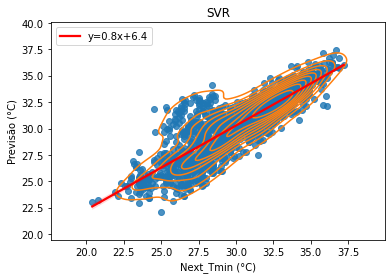

In [8]:
slope, intercept, r_value, p_value, std_err = stats.linregress(y_scaler_fit_Tmax.inverse_transform(y_test_Tmax),y_scaler_fit_Tmax.inverse_transform(yfit))
ax = sns.regplot(x=y_scaler_fit_Tmax.inverse_transform(y_test_Tmax), y=y_scaler_fit_Tmax.inverse_transform(yfit),line_kws={'color': 'red','label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
sns.kdeplot(y_scaler_fit_Tmax.inverse_transform(y_test_Tmax), y_scaler_fit_Tmax.inverse_transform(yfit))
ax.legend(loc='upper left')
ax.set(xlabel='Next_Tmin (°C)', ylabel='Previsão (°C)', title='SVR')
ax.figure.savefig("SVR_tmax.jpeg")

### Unique Station

In [9]:
yfit_st1 = svr_Tmax.predict(X_test_st1)
print("R-squared:",  r2_score(y_scaler_fit_Tmax.inverse_transform(y_test_Tmax_st1),y_scaler_fit_Tmax.inverse_transform(yfit_st1)))
print("MSE:", mean_squared_error(y_scaler_fit_Tmax.inverse_transform(y_test_Tmax_st1), y_scaler_fit_Tmax.inverse_transform(yfit_st1)))


R-squared: 0.7170368105024928
MSE: 2.406268469652395


In [10]:
y_test_Tmax_st1_frame = y_test_Tmax_st1.to_frame('Next_Tmax')
y_test_Tmax_st1_frame['Next_Tmax'] = y_scaler_fit_Tmax.inverse_transform(y_test_Tmax_st1)
forecast_results = pd.merge(X_test_st1, y_test_Tmax_st1_frame, left_index=True, right_index=True)
forecast_results = forecast_results.reset_index()
forecast_results = forecast_results.merge(pd.DataFrame(y_scaler_fit_Tmax.inverse_transform(yfit_st1),columns=['Previsão']).reset_index(drop=True), left_index=True, right_index=True)
forecast_results.head()

,station,Date,Year,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Previsão
0,1.0000000000,2017-06-30,2017,-0.6353088184,-1.3677698573,0.1786262381,1.3296752649,-0.9846526951,-1.1434685968,-0.3077624363,...,-0.2896729941,-0.2525800675,-0.1928158068,1.1906687093,-0.0008005538,2.7726693600,1.1163202881,1.5175509274,29.2000000000,28.3523554128
1,1.0000000000,2017-07-01,2017,-0.1975405447,-1.4093038588,2.4081613579,1.6303044350,-1.8206951910,-0.3916778506,1.0452531562,...,0.0044358885,0.4212376731,2.5402188894,1.1906687093,-0.0008005538,2.7726693600,1.1163202881,1.5054912834,24.1000000000,24.6410321143
2,1.0000000000,2017-07-02,2017,-2.0159626049,-1.0770318467,2.5316435620,1.6313746261,-1.9865524721,-0.6483755441,1.6574241297,...,6.9196671336,-0.2449624428,-0.1149365838,1.1906687093,-0.0008005538,2.7726693600,1.1163202881,1.4921225140,25.5000000000,27.0757382125
3,1.0000000000,2017-07-03,2017,-1.6118688137,-1.1185658482,0.1989934770,1.1605716197,-0.1451819785,-0.7643095525,0.0932883947,...,-0.2896729941,-0.2525800675,-0.2308736478,1.1906687093,-0.0008005538,2.7726693600,1.1163202881,1.4774400722,29.9000000000,27.4280342367
4,1.0000000000,2017-07-04,2017,-0.3995874402,-0.5786238285,-0.3558916090,0.0327526714,-0.0197111715,-0.4632657877,-0.3097391219,...,-0.2896729941,-0.2525800675,-0.2308736478,1.1906687093,-0.0008005538,2.7726693600,1.1163202881,1.4614439534,30.0000000000,31.1556694776


In [11]:
fig = px.line(forecast_results, x='Date', y=['Next_Tmax','Previsão'],labels={'value':"Temperatura Máxima Seoul (°C)"},title='Previsão Modelo SVR (Temperatura Máxima T+1)',width=800, height=400)
fig.show()

## Model Implementation for Tmin

In [12]:
def evaluate(v):
    C,e = v
    model = LinearSVR(C=C, epsilon=e)
    svr = model.fit(X_train, y_train_Tmin.ravel())
    yfit = svr.predict(X_test)
    return mean_squared_error(y_test_Tmin,yfit)

In [13]:
bounds = [[0.1,15],[0.0001,1]]
result = differential_evolution(evaluate, bounds, disp=True, maxiter=30)
result['x']

differential_evolution step 1: f(x)= 0.12973
differential_evolution step 2: f(x)= 0.12973
differential_evolution step 3: f(x)= 0.12973
differential_evolution step 4: f(x)= 0.129005
differential_evolution step 5: f(x)= 0.129005
differential_evolution step 6: f(x)= 0.129005


array([2.58389143, 0.42273709])

In [14]:
model = LinearSVR(C=result['x'][0], epsilon=result['x'][1])
svr_Tmin = model.fit(X_train,y_train_Tmin.ravel())
yfit_Tmin = svr_Tmin.predict(X_test)
score = svr_Tmin.score(X_test,y_test_Tmin)
print("R-squared:",  r2_score(y_scaler_fit_Tmax.inverse_transform(y_test_Tmin), y_scaler_fit_Tmax.inverse_transform(yfit_Tmin)))
print("MSE:", mean_squared_error(y_scaler_fit_Tmax.inverse_transform(y_test_Tmin),y_scaler_fit_Tmax.inverse_transform(yfit_Tmin)))

R-squared: 0.8705046895440152
MSE: 1.2458791034705112


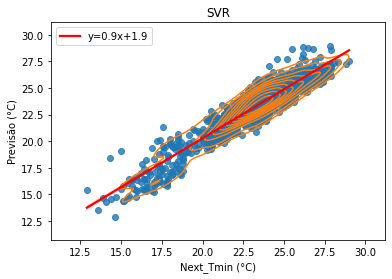

In [15]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    y_scaler_fit_Tmin.inverse_transform(y_test_Tmin), y_scaler_fit_Tmin.inverse_transform(yfit_Tmin))
ax = sns.regplot(x=y_scaler_fit_Tmin.inverse_transform(y_test_Tmin), y=y_scaler_fit_Tmin.inverse_transform(
    yfit_Tmin), line_kws={'color': 'red', 'label': "y={0:.1f}x+{1:.1f}".format(slope, intercept)})
sns.kdeplot(y_scaler_fit_Tmin.inverse_transform(y_test_Tmin),
            y_scaler_fit_Tmin.inverse_transform(yfit_Tmin))
ax.legend(loc='upper left')
ax.set(xlabel='Next_Tmin (°C)', ylabel='Previsão (°C)', title='SVR')
ax.figure.savefig("SVR_tmin.jpeg")


### Unique Station

In [16]:
yfit_st1 = svr_Tmin.predict(X_test_st1)
print("R-squared:",  r2_score(y_scaler_fit_Tmin.inverse_transform(y_test_Tmin_st1),y_scaler_fit_Tmin.inverse_transform(yfit_st1)))
print("MSE:", mean_squared_error(y_scaler_fit_Tmin.inverse_transform(y_test_Tmin_st1), y_scaler_fit_Tmin.inverse_transform(yfit_st1)))


R-squared: 0.8807067767786201
MSE: 0.6397079058088607


In [17]:
y_test_Tmin_st1_frame = y_test_Tmin_st1.to_frame('Next_Tmin')
y_test_Tmin_st1_frame['Next_Tmin'] = y_scaler_fit_Tmin.inverse_transform(y_test_Tmin_st1)
forecast_results = pd.merge(X_test, y_test_Tmin_st1_frame, left_index=True, right_index=True)
forecast_results = forecast_results.reset_index()
forecast_results = forecast_results.merge(pd.DataFrame(y_scaler_fit_Tmin.inverse_transform(yfit_st1), columns=['Previsão']).reset_index(drop=True), left_index=True, right_index=True)
forecast_results.head()


,station,Date,Year,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmin,Previsão
0,1.0000000000,2017-06-30,2017,-0.6353088184,-1.3677698573,0.1786262381,1.3296752649,-0.9846526951,-1.1434685968,-0.3077624363,...,-0.2896729941,-0.2525800675,-0.1928158068,1.1906687093,-0.0008005538,2.7726693600,1.1163202881,1.5175509274,19.6000000000,19.3969590742
1,1.0000000000,2017-07-01,2017,-0.1975405447,-1.4093038588,2.4081613579,1.6303044350,-1.8206951910,-0.3916778506,1.0452531562,...,0.0044358885,0.4212376731,2.5402188894,1.1906687093,-0.0008005538,2.7726693600,1.1163202881,1.5054912834,20.4000000000,20.0748537100
2,1.0000000000,2017-07-02,2017,-2.0159626049,-1.0770318467,2.5316435620,1.6313746261,-1.9865524721,-0.6483755441,1.6574241297,...,6.9196671336,-0.2449624428,-0.1149365838,1.1906687093,-0.0008005538,2.7726693600,1.1163202881,1.4921225140,20.5000000000,19.2632813681
3,1.0000000000,2017-07-03,2017,-1.6118688137,-1.1185658482,0.1989934770,1.1605716197,-0.1451819785,-0.7643095525,0.0932883947,...,-0.2896729941,-0.2525800675,-0.2308736478,1.1906687093,-0.0008005538,2.7726693600,1.1163202881,1.4774400722,20.6000000000,19.5631370452
4,1.0000000000,2017-07-04,2017,-0.3995874402,-0.5786238285,-0.3558916090,0.0327526714,-0.0197111715,-0.4632657877,-0.3097391219,...,-0.2896729941,-0.2525800675,-0.2308736478,1.1906687093,-0.0008005538,2.7726693600,1.1163202881,1.4614439534,20.5000000000,20.9317148666


In [18]:
fig = px.line(forecast_results, x='Date', y=['Next_Tmin','Previsão'],labels={'value':"Temperatura Mínima Seoul (°C)"},title='Previsão Modelo SVR (Temperatura Mínima T+1)',width=800, height=400)
fig.show()

## Model Implementation for Tmax

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ReduceLROnPlateau

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
pd.options.display.float_format = '{:,.10f}'.format
db = pd.read_csv('Bias_correction_ucl.csv').dropna()
db.Date = pd.to_datetime(db.Date)
db['Year'] = db.Date.dt.year
db = db.set_index(['station', 'Date', 'Year'])
db = db[(np.abs(stats.zscore(db)) < 6).all(axis=1)]
target = db[['Next_Tmax', 'Next_Tmin']]
features = db.drop(['Next_Tmax', 'Next_Tmin'], axis=1)


In [4]:
X_train = features.loc[pd.IndexSlice[:, :, [2013, 2014, 2015, 2016]], :]
X_test = features.loc[pd.IndexSlice[:, :, [2017]], :]
y_train_Tmax = target.loc[pd.IndexSlice[:, :, [
    2013, 2014, 2015, 2016]], :]['Next_Tmax']
y_test_Tmax = target.loc[pd.IndexSlice[:, :, [2017]], :]['Next_Tmax']
y_train_Tmin = target.loc[pd.IndexSlice[:, :, [
    2013, 2014, 2015, 2016]], :]['Next_Tmin']
y_test_Tmin = target.loc[pd.IndexSlice[:, :, [2017]], :]['Next_Tmin']

X_train_st1 = features.loc[pd.IndexSlice[[
    1], :, [2013, 2014, 2015, 2016]], :]
X_test_st1 = features.loc[pd.IndexSlice[[1], :, [2017]], :]
y_train_Tmax_st1 = target.loc[pd.IndexSlice[[
    1], :, [2013, 2014, 2015, 2016]], :]['Next_Tmax']
y_test_Tmax_st1 = target.loc[pd.IndexSlice[[
    1], :, [2017]], :]['Next_Tmax']
y_train_Tmin_st1 = target.loc[pd.IndexSlice[[
    1], :, [2013, 2014, 2015, 2016]], :]['Next_Tmin']
y_test_Tmin_st1 = target.loc[pd.IndexSlice[[
    1], :, [2017]], :]['Next_Tmin']


### All 25 stations

In [7]:
n_input = len(X_train.columns)
model = Sequential()
model.add(Dense(80, activation='relu', input_shape=(n_input,)))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)
history = model.fit(X_train, y_train_Tmax, epochs=1000, verbose=1,
                    callbacks=[reduce_lr], shuffle=True, validation_data=(X_test, y_test_Tmax))
yfit_Tmax_mlp = model.predict(X_test)
print("R-squared:",  r2_score(y_test_Tmax,yfit_Tmax_mlp))
print("MSE:", mean_squared_error(y_test_Tmax,yfit_Tmax_mlp))


Epoch 1/1000
186/186 [==============================] - 2s 4ms/step - loss: 3115.1881 - val_loss: 10.3806
Epoch 2/1000
186/186 [==============================] - 0s 2ms/step - loss: 17.9715 - val_loss: 10.1283
Epoch 3/1000
186/186 [==============================] - 0s 2ms/step - loss: 17.3012 - val_loss: 9.3032
Epoch 4/1000
186/186 [==============================] - 0s 2ms/step - loss: 16.9412 - val_loss: 9.0722
Epoch 5/1000
186/186 [==============================] - 0s 2ms/step - loss: 15.8702 - val_loss: 8.3554
Epoch 6/1000
186/186 [==============================] - 0s 2ms/step - loss: 14.6939 - val_loss: 7.9449
Epoch 7/1000
186/186 [==============================] - 0s 2ms/step - loss: 14.3521 - val_loss: 8.1091
Epoch 8/1000
186/186 [==============================] - 0s 2ms/step - loss: 13.1099 - val_loss: 7.4617
Epoch 9/1000
186/186 [==============================] - 0s 2ms/step - loss: 12.7356 - val_loss: 7.1458
Epoch 10/1000
186/186 [==============================] - 0s 2ms/step 

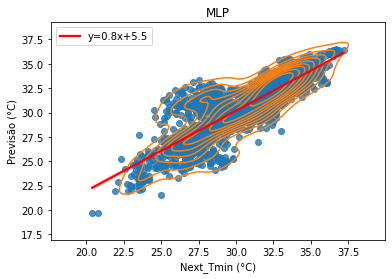

In [23]:
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test_Tmax,yfit_Tmax_mlp.flatten())
ax = sns.regplot(x=y_test_Tmax, y= yfit_Tmax_mlp.flatten(), line_kws={'color': 'red', 'label': "y={0:.1f}x+{1:.1f}".format(slope, intercept)})
sns.kdeplot(y_test_Tmax,yfit_Tmax_mlp.flatten())
ax.legend(loc='upper left')
ax.set(xlabel='Next_Tmin (°C)', ylabel='Previsão (°C)', title='MLP')
ax.figure.savefig("MLP_tmax.jpeg")


### Unique Station

In [12]:
yfit_Tmax_mlp = model.predict(X_test_st1)
print("R-squared:",  r2_score(y_test_Tmax_st1,yfit_Tmax_mlp))
print("MSE:", mean_squared_error(y_test_Tmax_st1,yfit_Tmax_mlp))


R-squared: 0.5788754286343067
MSE: 3.5811682066231247


In [13]:
forecast_results = pd.merge(X_test_st1, pd.DataFrame(y_test_Tmax_st1, columns=['Next_Tmax']), left_index=True, right_index=True, how='left').reset_index()
forecast_results = forecast_results.merge(pd.DataFrame(yfit_Tmax_mlp.flatten(), columns=[
                                          'Previsão']), left_index=True, right_index=True)
forecast_results.head()


,station,Date,Year,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Previsão
0,1.0000000000,2017-06-30,2017,27.9000000000,19.9000000000,58.9641227700,97.8213729900,26.7983751400,20.8287135200,6.3978330790,...,0.0000000000,0.0000000000,0.0258895670,37.6046000000,126.9910000000,212.3350000000,2.7850000000,"5,992.8959960000",29.2000000000,27.0313472748
1,1.0000000000,2017-07-01,2017,29.2000000000,19.8000000000,91.3008728000,99.9924240100,24.3613413300,22.5986772600,9.3222700950,...,0.3799591550,0.5277483250,1.8850881670,37.6046000000,126.9910000000,212.3350000000,2.7850000000,"5,987.7187500000",24.1000000000,23.6192111969
2,1.0000000000,2017-07-02,2017,23.8000000000,20.6000000000,93.0918350200,100.0001526000,23.8778733200,21.9943261000,10.6454296100,...,9.3137438050,0.0059662850,0.0788683830,37.6046000000,126.9910000000,212.3350000000,2.7850000000,"5,981.9794920000",25.5000000000,23.0666294098
3,1.0000000000,2017-07-03,2017,25.0000000000,20.5000000000,59.2595253000,96.6001586900,29.2454020900,21.7213791500,7.2646729750,...,0.0000000000,0.0000000000,0.0000000000,37.6046000000,126.9910000000,212.3350000000,2.7850000000,"5,975.6762700000",29.9000000000,28.1263046265
4,1.0000000000,2017-07-04,2017,28.6000000000,21.8000000000,51.2115783700,88.4553985600,29.6111449800,22.4301356100,6.3935606280,...,0.0000000000,0.0000000000,0.0000000000,37.6046000000,126.9910000000,212.3350000000,2.7850000000,"5,968.8090820000",30.0000000000,31.0402355194


In [14]:
fig = px.line(forecast_results, x='Date', y=['Next_Tmax', 'Previsão'], labels={
              'value': "Temperatura Máxima Seoul (°C)"}, title='Previsão Modelo MLP (Temperatura Máxima T+1)', width=800, height=400)
fig.show()


## Model Implementation for Tmin

In [27]:
n_input = len(X_train.columns)
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(n_input,)))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train_Tmin, epochs=1000, verbose=0)
yfit_Tmin_mlp = model.predict(X_test)
print("R-squared:",  r2_score(y_test_Tmin,yfit_Tmin_mlp))
print("MSE:", mean_squared_error(y_test_Tmin,yfit_Tmin_mlp))


R-squared: 0.8580604251708175
MSE: 0.8899243322390428


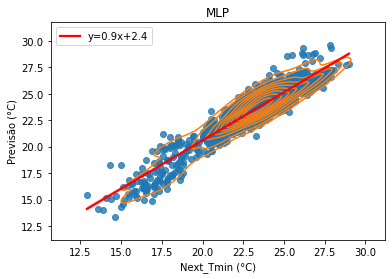

In [28]:
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test_Tmin, yfit_Tmin_mlp.flatten())
ax = sns.regplot(x=y_test_Tmin, y=yfit_Tmin_mlp.flatten(), line_kws={'color': 'red', 'label': "y={0:.1f}x+{1:.1f}".format(slope, intercept)})
sns.kdeplot(y_test_Tmin, yfit_Tmin_mlp.flatten())
ax.legend(loc='upper left')
ax.set(xlabel='Next_Tmin (°C)', ylabel='Previsão (°C)', title='MLP')
ax.figure.savefig("MLP_tmax.jpeg")


### Unique Station

In [29]:
yfit_Tmin_mlp = model.predict(X_test_st1)
print("R-squared:",  r2_score(y_test_Tmin_st1, yfit_Tmin_mlp))
print("MSE:", mean_squared_error(y_test_Tmin_st1, yfit_Tmin_mlp))


R-squared: 0.9187482463134744
MSE: 0.4357111643940324


In [30]:
forecast_results = pd.merge(X_test_st1, pd.DataFrame(y_test_Tmin_st1, columns=[
                            'Next_Tmin']), left_index=True, right_index=True, how='left').reset_index()
forecast_results = forecast_results.merge(pd.DataFrame(yfit_Tmin_mlp.flatten(), columns=[
                                          'Previsão']), left_index=True, right_index=True)
forecast_results.head()


,station,Date,Year,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmin,Previsão
0,1.0000000000,2017-06-30,2017,27.9000000000,19.9000000000,58.9641227700,97.8213729900,26.7983751400,20.8287135200,6.3978330790,...,0.0000000000,0.0000000000,0.0258895670,37.6046000000,126.9910000000,212.3350000000,2.7850000000,"5,992.8959960000",19.6000000000,19.8337440491
1,1.0000000000,2017-07-01,2017,29.2000000000,19.8000000000,91.3008728000,99.9924240100,24.3613413300,22.5986772600,9.3222700950,...,0.3799591550,0.5277483250,1.8850881670,37.6046000000,126.9910000000,212.3350000000,2.7850000000,"5,987.7187500000",20.4000000000,21.0606498718
2,1.0000000000,2017-07-02,2017,23.8000000000,20.6000000000,93.0918350200,100.0001526000,23.8778733200,21.9943261000,10.6454296100,...,9.3137438050,0.0059662850,0.0788683830,37.6046000000,126.9910000000,212.3350000000,2.7850000000,"5,981.9794920000",20.5000000000,20.1617965698
3,1.0000000000,2017-07-03,2017,25.0000000000,20.5000000000,59.2595253000,96.6001586900,29.2454020900,21.7213791500,7.2646729750,...,0.0000000000,0.0000000000,0.0000000000,37.6046000000,126.9910000000,212.3350000000,2.7850000000,"5,975.6762700000",20.6000000000,20.5818195343
4,1.0000000000,2017-07-04,2017,28.6000000000,21.8000000000,51.2115783700,88.4553985600,29.6111449800,22.4301356100,6.3935606280,...,0.0000000000,0.0000000000,0.0000000000,37.6046000000,126.9910000000,212.3350000000,2.7850000000,"5,968.8090820000",20.5000000000,21.5287532806


In [31]:
fig = px.line(forecast_results, x='Date', y=['Next_Tmin', 'Previsão'], labels={'value': 'Temperatura Minima Seoul (°C)'}, title='Previsão Modelo MLP (Temperatura Mínima T+1)', width=800, height=400)
fig.show()


# Random Forest

## Model Implementation fo Tmax

### For all 25 stations

In [35]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(
    n_estimators=200, criterion='mse', random_state=0)
regressor.fit(X_train, y_train_Tmax)
yfit_Tmax_RF = regressor.predict(X_test)
print("R-squared:", r2_score(y_test_Tmax, yfit_Tmax_RF))
print("MSE:", mean_squared_error(y_test_Tmax, yfit_Tmax_RF))


R-squared: 0.6288600510029183
MSE: 0.379740347098654


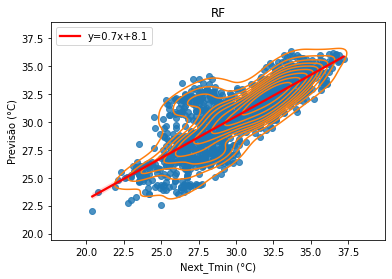

In [40]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    y_scaler_fit_Tmax.inverse_transform(y_test_Tmax), y_scaler_fit_Tmax.inverse_transform(yfit_Tmax_RF))
ax = sns.regplot(x=y_scaler_fit_Tmax.inverse_transform(y_test_Tmax), y=y_scaler_fit_Tmax.inverse_transform(
    yfit_Tmax_RF), line_kws={'color': 'red', 'label': "y={0:.1f}x+{1:.1f}".format(slope, intercept)})
sns.kdeplot(y_scaler_fit_Tmax.inverse_transform(y_test_Tmax),
            y_scaler_fit_Tmax.inverse_transform(yfit_Tmax_RF))
ax.legend(loc='upper left')
ax.set(xlabel='Next_Tmin (°C)', ylabel='Previsão (°C)', title='RF')
ax.figure.savefig("RF_tmax.jpeg")


In [23]:
yfit_RF = regressor.predict(X_test_st1)
print("R-squared:", r2_score(y_test_Tmax_st1, yfit_RF))
print("MSE:", mean_squared_error(y_test_Tmax_st1, yfit_RF))


R-squared: 0.6890073099989509
MSE: 0.27686293507533666


In [25]:
y_test_Tmax_st1_frame = y_test_Tmax_st1.to_frame('Next_Tmax')
y_test_Tmax_st1_frame['Next_Tmax'] = y_scaler_fit_Tmax.inverse_transform(
    y_test_Tmax_st1)
forecast_results = pd.merge(
    X_test_st1, y_test_Tmax_st1_frame, left_index=True, right_index=True)
forecast_results = forecast_results.reset_index()
forecast_results = forecast_results.merge(pd.DataFrame(y_scaler_fit_Tmax.inverse_transform(
    yfit_RF), columns=['Previsão']).reset_index(drop=True), left_index=True, right_index=True)
forecast_results.head()


,station,Date,Year,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Previsão
0,1.0000000000,2017-06-30,2017,-0.6353088184,-1.3677698573,0.1786262381,1.3296752649,-0.9846526951,-1.1434685968,-0.3077624363,...,-0.2896729941,-0.2525800675,-0.1928158068,1.1906687093,-0.0008005538,2.7726693600,1.1163202881,1.5175509274,29.2000000000,27.6280000000
1,1.0000000000,2017-07-01,2017,-0.1975405447,-1.4093038588,2.4081613579,1.6303044350,-1.8206951910,-0.3916778506,1.0452531562,...,0.0044358885,0.4212376731,2.5402188894,1.1906687093,-0.0008005538,2.7726693600,1.1163202881,1.5054912834,24.1000000000,24.1250000000
2,1.0000000000,2017-07-02,2017,-2.0159626049,-1.0770318467,2.5316435620,1.6313746261,-1.9865524721,-0.6483755441,1.6574241297,...,6.9196671336,-0.2449624428,-0.1149365838,1.1906687093,-0.0008005538,2.7726693600,1.1163202881,1.4921225140,25.5000000000,24.1860000000
3,1.0000000000,2017-07-03,2017,-1.6118688137,-1.1185658482,0.1989934770,1.1605716197,-0.1451819785,-0.7643095525,0.0932883947,...,-0.2896729941,-0.2525800675,-0.2308736478,1.1906687093,-0.0008005538,2.7726693600,1.1163202881,1.4774400722,29.9000000000,27.9325000000
4,1.0000000000,2017-07-04,2017,-0.3995874402,-0.5786238285,-0.3558916090,0.0327526714,-0.0197111715,-0.4632657877,-0.3097391219,...,-0.2896729941,-0.2525800675,-0.2308736478,1.1906687093,-0.0008005538,2.7726693600,1.1163202881,1.4614439534,30.0000000000,29.9050000000


In [46]:
fig = px.line(forecast_results, x='Date', y=['Next_Tmax', 'Previsão'], labels={
              'value': "Temperatura Máxima Seoul (°C)"}, title='Previsão Modelo RF (Temperatura Máxima T+1)', width=800, height=400)
fig.show()


ValueError: All arguments should have the same length. The length of argument `y` is 2, whereas the length of  previously-processed arguments ['Date'] is 61

### Model Implementation For Tmin

In [52]:
regressor = RandomForestRegressor(
    n_estimators=200, criterion='mse', random_state=0)
regressor.fit(X_train, y_train_Tmin)
yfit_Tmin_RF = regressor.predict(X_test)
print("R-squared:", r2_score(y_test_Tmin, yfit_Tmin_RF))
print("MSE:", mean_squared_error(y_test_Tmin, yfit_Tmin_RF))


R-squared: 0.8708354052284503
MSE: 0.13009656977483236


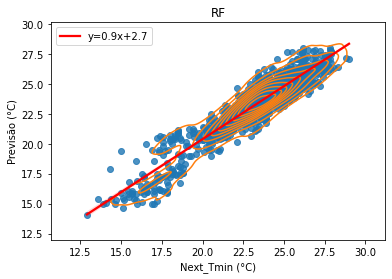

In [53]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    y_scaler_fit_Tmin.inverse_transform(y_test_Tmin), y_scaler_fit_Tmin.inverse_transform(yfit_Tmin_RF))
ax = sns.regplot(x=y_scaler_fit_Tmin.inverse_transform(y_test_Tmin), y=y_scaler_fit_Tmin.inverse_transform(
    yfit_Tmin_RF), line_kws={'color': 'red', 'label': "y={0:.1f}x+{1:.1f}".format(slope, intercept)})
sns.kdeplot(y_scaler_fit_Tmin.inverse_transform(y_test_Tmin),
            y_scaler_fit_Tmin.inverse_transform(yfit_Tmin_RF))
ax.legend(loc='upper left')
ax.set(xlabel='Next_Tmin (°C)', ylabel='Previsão (°C)', title='RF')
ax.figure.savefig("RF_tmin.jpeg")


In [57]:
yfit_Tmin_RF = regressor.predict(X_test_st1)
print("R-squared:", r2_score(y_test_Tmin_st1, yfit_Tmin_RF))
print("MSE:", mean_squared_error(y_test_Tmin_st1, yfit_Tmin_RF))


R-squared: 0.8884843593325582
MSE: 0.09606706162926369


In [55]:
y_test_Tmin_st1_frame = y_test_Tmin_st1.to_frame('Next_Tmin')
y_test_Tmin_st1_frame['Next_Tmin'] = y_scaler_fit_Tmin.inverse_transform(
    y_test_Tmin_st1)
forecast_results = pd.merge(
    X_test_st1, y_test_Tmin_st1_frame, left_index=True, right_index=True)
forecast_results = forecast_results.reset_index()
forecast_results = forecast_results.merge(pd.DataFrame(y_scaler_fit_Tmin.inverse_transform(
    yfit_Tmin_RF), columns=['Previsão']).reset_index(drop=True), left_index=True, right_index=True)
forecast_results.head()


,station,Date,Year,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmin,Previsão
0,1.0000000000,2017-06-30,2017,-0.6353088184,-1.3677698573,0.1786262381,1.3296752649,-0.9846526951,-1.1434685968,-0.3077624363,...,-0.2896729941,-0.2525800675,-0.1928158068,1.1906687093,-0.0008005538,2.7726693600,1.1163202881,1.5175509274,19.6000000000,19.8960000000
1,1.0000000000,2017-07-01,2017,-0.1975405447,-1.4093038588,2.4081613579,1.6303044350,-1.8206951910,-0.3916778506,1.0452531562,...,0.0044358885,0.4212376731,2.5402188894,1.1906687093,-0.0008005538,2.7726693600,1.1163202881,1.5054912834,20.4000000000,21.2295000000
2,1.0000000000,2017-07-02,2017,-2.0159626049,-1.0770318467,2.5316435620,1.6313746261,-1.9865524721,-0.6483755441,1.6574241297,...,6.9196671336,-0.2449624428,-0.1149365838,1.1906687093,-0.0008005538,2.7726693600,1.1163202881,1.4921225140,20.5000000000,20.4970000000
3,1.0000000000,2017-07-03,2017,-1.6118688137,-1.1185658482,0.1989934770,1.1605716197,-0.1451819785,-0.7643095525,0.0932883947,...,-0.2896729941,-0.2525800675,-0.2308736478,1.1906687093,-0.0008005538,2.7726693600,1.1163202881,1.4774400722,20.6000000000,20.4665000000
4,1.0000000000,2017-07-04,2017,-0.3995874402,-0.5786238285,-0.3558916090,0.0327526714,-0.0197111715,-0.4632657877,-0.3097391219,...,-0.2896729941,-0.2525800675,-0.2308736478,1.1906687093,-0.0008005538,2.7726693600,1.1163202881,1.4614439534,20.5000000000,21.1250000000


In [56]:
fig = px.line(forecast_results, x='Date', y=['Next_Tmin', 'Previsão'], labels={
              'value': "Temperatura Máxima Seoul (°C)"}, title='Previsão Modelo RF (Temperatura Mínima T+1)', width=800, height=400)
fig.show()
